In [1]:
import os

import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers, models

from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
TARGET_SIZE = (144, 256)

In [3]:
def parse_filename(filename):
    components = filename.split("_")
    offset = 0
    
    if "-" in components[1]:
        offset = 1
    
    if len(components) < 6 + offset:
        return False, []
   
    x = int(components[1 + offset])
    y = int(components[2 + offset])
    z = int(components[3 + offset])
    r = int(components[4 + offset])
    is_flying = int(components[5 + offset].split(".")[0])

    return True, [x, y, z, r, is_flying]

In [4]:
image_data = []
label_data = []

for date_folder in os.listdir("data"):
    date_folder_path = os.path.join("data", date_folder)

    if os.path.isdir(date_folder_path):
        for filename in os.listdir(date_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(date_folder_path, filename)
                valid, components = parse_filename(filename)
                
                if valid:
                    image_data.append(image_path)
                    label_data.append(components)

In [5]:
label_data = np.array(label_data)

shuffle_index = np.arange(len(label_data))
np.random.shuffle(shuffle_index)

# image_data = image_data[shuffle_index]
label_data = label_data[shuffle_index]
sc
def preprocess_image(image_path):
    image = load_img(image_path, target_size=TARGET_SIZE) 
    image = img_to_array(image) / 255.0

    return image

image_data = np.array([preprocess_image(image_path) for image_path in image_data])
image_train, image_val, label_train, label_val = train_test_split(
    image_data, label_data, test_size=0.2, random_state=42)

In [6]:
print(label_train.shape)

(5890, 5)


In [7]:
label_train_x = tf.keras.utils.to_categorical(label_train[:, 0], num_classes=3)
label_train_y = tf.keras.utils.to_categorical(label_train[:, 1], num_classes=3)
label_train_z = tf.keras.utils.to_categorical(label_train[:, 2], num_classes=3)
label_train_r = tf.keras.utils.to_categorical(label_train[:, 3], num_classes=3)
label_train_is_flying = tf.keras.utils.to_categorical(label_train[:, 4], num_classes=3)

label_val_x = tf.keras.utils.to_categorical(label_val[:, 0], num_classes=3)
label_val_y = tf.keras.utils.to_categorical(label_val[:, 1], num_classes=3)
label_val_z = tf.keras.utils.to_categorical(label_val[:, 2], num_classes=3)
label_val_r = tf.keras.utils.to_categorical(label_val[:, 3], num_classes=3)
label_val_is_flying = tf.keras.utils.to_categorical(label_val[:, 4], num_classes=3)


In [51]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
model.add(layers.Flatten())

x_output = layers.Dense(3, activation='softmax', name='x_output')(model.layers[-1].output)
y_output = layers.Dense(3, activation='softmax', name='y_output')(model.layers[-1].output)
z_output = layers.Dense(3, activation='softmax', name='z_output')(model.layers[-1].output)
r_output = layers.Dense(3, activation='softmax', name='r_output')(model.layers[-1].output)
is_flying_output = layers.Dense(3, activation='softmax', name='is_flying_output')(model.layers[-1].output)

multi_output_model = models.Model(inputs=model.inputs, outputs=[x_output, y_output, z_output, r_output, is_flying_output])

losses = {
    'x_output': 'categorical_crossentropy',
    'y_output': 'categorical_crossentropy',
    'z_output': 'categorical_crossentropy',
    'r_output': 'categorical_crossentropy',
    'is_flying_output': 'categorical_crossentropy',
}

multi_output_model.compile(optimizer='adam', loss=losses)
multi_output_model.fit(image_train, {'x_output': label_train_x, 'y_output': label_train_y, 'z_output': label_train_z, 'r_output': label_train_r, 'is_flying_output': label_train_is_flying}, epochs=1, batch_size=5)

1101/1178 [===========================>..] - ETA: 0s - loss: 3.1919 - x_output_loss: 0.7387 - y_output_loss: 0.4578 - z_output_loss: 1.0139 - r_output_loss: 0.7975 - is_flying_output_loss: 0.1840

In [9]:
import matplotlib.pyplot as plt
import random

In [10]:
def predict(filename):
    image = preprocess_image(filename)
    image = np.expand_dims(image, axis=0)

    predictions = multi_output_model.predict(image)
    x_pred, y_pred, z_pred, r_pred, is_flying_pred = predictions

    x_pred = np.argmax(x_pred)
    y_pred = np.argmax(y_pred)
    z_pred = np.argmax(z_pred)
    r_pred = np.argmax(r_pred)
    is_flying_pred = np.argmax(is_flying_pred)

    return x_pred, y_pred, z_pred, r_pred, is_flying_pred


In [15]:
def predict_from_val(valid):
    image = np.expand_dims(valid, axis=0)
    plt.imshow(image[0])

    predictions = multi_output_model.predict(image)
    x_pred, y_pred, z_pred, r_pred, is_flying_pred = predictions

    x_pred = np.argmax(x_pred)
    y_pred = np.argmax(y_pred)
    z_pred = np.argmax(z_pred)
    r_pred = np.argmax(r_pred)
    is_flying_pred = np.argmax(is_flying_pred)

    return x_pred, y_pred, z_pred, r_pred, is_flying_pred



1/1 [==============================] - 0s 15ms/step
(0, 0, 1, 0, 1)
[0 0 1 0 1]


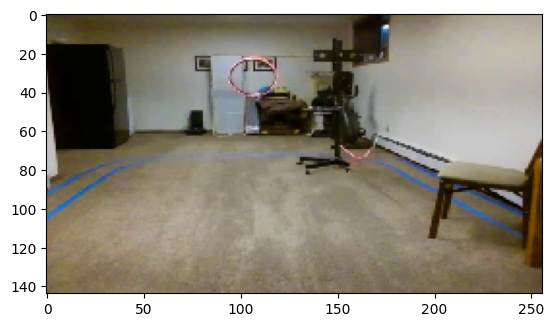

In [50]:
ran = random.randint(0, len(image_val))

print(predict_from_val(image_val[ran]))
print(label_val[ran])

In [13]:
print(predict("data/2023-08-03_17-26-04/169_17-27-41_0_0_0_0_1.png"))

1/1 [==============================] - 0s 14ms/step
(0, 0, 0, 0, 1)
